# Multimodal Agent with fastRAG and Haystack

*Notebook by Bilge Yucel ([X](https://x.com/bilgeycl), [Linkedin](https://www.linkedin.com/in/bilge-yucel/)) and Moshe Berchansky ([Linkedin](https://www.linkedin.com/in/moshe-berchansky-446515142))*

In this cookbook, we'll show you how to use the [4B Phi3.5 Vision model](https://huggingface.co/microsoft/Phi-3.5-vision-instruct) to build a multimodal conversational agent. This agent will use tools to perform multi-step reasoning through ReAct prompting and answer questions about the nutrition facts of different foods, leveraging **Haystack** and **fastRAG**.

> [fastRAG](https://github.com/IntelLabs/fastRAG) is a research framework developed by Intel Labs for efficient and optimized RAG pipelines. It is fully compatible with Haystack and includes novel and efficient RAG modules designed for efficient deployment on Intel hardware, including client and server CPUs (Xeon) and the Intel Gaudi AI accelerator.

## Development Environment

Enable GPU and install fastRAG. We don't need to install haystack-ai as it's installed with fastRAG:

In [ ]:
!pip install git+https://github.com/IntelLabs/fastRAG.git

## Getting the Data

Now, load some multi-modal data. As an example, you can use the [nutrition_data.json](https://github.com/IntelLabs/fastRAG/blob/main/assets/multi_modal_files/nutrition_data.json) file provided in the fastRAG repository. Each entry in this JSON contains a brief textual description, with a title and the image url.

In [2]:
import json

# Google Colab path
entries = json.load(open("/content/nutrition_data.json", "r"))

# Local path
# entries = json.load(open("fastRAG/assets/multi_modal_files/nutrition_data.json", "r"))

```json
{
	  "image_url": "https://m.media-amazon.com/images/I/71nh-zRJCSL.jpg",
	  "title": "Protein bar nutrition facts",
	  "content": "Protein bar nutrition facts"
}
```

## Indexing Pipeline

Let's create a basic pipeline to index each entry to your document store:

In [3]:
from haystack import Pipeline, Document
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.writers import DocumentWriter
from haystack.components.embedders import SentenceTransformersDocumentEmbedder

document_store = InMemoryDocumentStore()

index_pipeline = Pipeline()
index_pipeline.add_component(
    instance=SentenceTransformersDocumentEmbedder(model="sentence-transformers/all-MiniLM-L6-v2"), name="doc_embedder"
)
index_pipeline.add_component(
    instance=DocumentWriter(document_store=document_store), name="doc_writer"
)

index_pipeline.connect("doc_embedder.documents", "doc_writer.documents")

🚅 Components
  - doc_embedder: SentenceTransformersDocumentEmbedder
  - doc_writer: DocumentWriter
🛤️ Connections
  - doc_embedder.documents -> doc_writer.documents (List[Document])

We will embed the "content" of each entry and keep the other info as meta data of our Document object. As we're running the indexing pipeline, we'll convert the JSON entries into Haystack Documents:

In [ ]:
index_pipeline.run({
    "documents": [
        Document(
            content=entry["content"],
            meta={
                "title": entry["title"],
                "image_url": entry["image_url"]
            }
        ) for entry in entries
    ]
})


## Building a Retrieval Pipeline

Next, we create a document retrieval pipeline for the documents above. We will later use this pipeline as a tool.

This pipeline consists of:

- A [SentenceTransformersTextEmbedder](https://docs.haystack.deepset.ai/docs/sentencetransformerstextembedder), to embed our questions.
- An [InMemoryEmbeddingRetriever](https://docs.haystack.deepset.ai/docs/inmemoryembeddingretriever) to fetch the top-1 document.
- A [MultiModalPromptBuilder](https://github.com/IntelLabs/fastRAG/blob/main/fastrag/prompt_builders/multi_modal_prompt_builder.py), to construct the prompt that our multimodal Agent will eventually use.

The prompt for `MultiModalPromptBuilder` should include the `<|image_` tag. It's a placeholder for our model to inject the images into later on.

In [5]:
from haystack.components.embedders import SentenceTransformersTextEmbedder
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from fastrag.prompt_builders.multi_modal_prompt_builder import MultiModalPromptBuilder

template = """{% for document in documents %}
Image: <|image_
This image shows: {{ document.content }}
{% endfor %}
"""

retrieval_pipeline = Pipeline()
retrieval_pipeline.add_component("embedder", SentenceTransformersTextEmbedder(model="sentence-transformers/all-MiniLM-L6-v2"))
retrieval_pipeline.add_component("retriever", InMemoryEmbeddingRetriever(document_store=document_store, top_k=1))
retrieval_pipeline.add_component("prompt_builder", MultiModalPromptBuilder(template=template))

retrieval_pipeline.connect("embedder.embedding", "retriever.query_embedding")
retrieval_pipeline.connect("retriever", "prompt_builder.documents")

🚅 Components
  - embedder: SentenceTransformersTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt_builder: MultiModalPromptBuilder
🛤️ Connections
  - embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])

In [6]:
retrieval_pipeline.run({"embedder":{"text": "Protein bar"}})

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{'prompt_builder': {'prompt': '\nImage: <|image_\nThis image shows: Protein bar with chocolate peanut butter nutrition facts per bar (50g)\n',
  'images': ['/9j/4AAQSkZJRgABAQAAAQABAAD/4QBKRXhpZgAASUkqAAgAAAABAGmHBAABAAAAGgAAAAAAAAABAIaSBwAVAAAALAAAAAAAAAAAAAAAAAAAAFZlcnNpb24gMS4wLjAA/9sAQwALCAgICAgLCAgLEAsJCxATDgsLDhMWEhITEhIWFRETEhITERUVGRobGhkVISEkJCEhMC8vLzA2NjY2NjY2NjY2/9sAQwEMCwsMDQwPDQ0PEw4ODhMUDg8PDhQaEhIUEhIaIhgVFRUVGCIeIBsbGyAeJSUiIiUlLy8sLy82NjY2NjY2NjY2/8AAEQgFFAUUAwEiAAIRAQMRAf/EAB8AAAEFAQEBAQEBAAAAAAAAAAABAgMEBQYHCAkKC//EALUQAAIBAwMCBAMFBQQEAAABfQECAwAEEQUSITFBBhNRYQcicRQygZGhCCNCscEVUtHwJDNicoIJChYXGBkaJSYnKCkqNDU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6g4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre4ubrCw8TFxsfIycrS09TV1tfY2drh4uPk5ebn6Onq8fLz9PX29/j5+v/EAB8BAAMBAQEBAQEBAQEAAAAAAAABAgMEBQYHCAkKC//EALURAAIBAgQEAwQHBQQEAAECdwABAgMRBAUhMQYSQVEHYXETIjKBCBRCkaGxwQkjM1LwFWJy0QoWJDThJfEXGBkaJicoKSo1Njc4OTpDREVGR0hJSlNUVVZXWFlaY2RlZmdoaWpzdHV2d3h5eoKDhIWGh4iJipKTlJWWl5iZmqK

## Defining a Tool

With our retrieval pipeline ready, we can create our Tool using the [`DocWithImageHaystackQueryTool`](https://github.com/IntelLabs/fastRAG/blob/4f73883ca85abf702eb81fd4a384a872b9fd3767/fastrag/agents/tools/tools.py#L69) component from fastRAG. `DocWithImageHaystackQueryTool` can use Haystack v2 pipelines as a tool with fastRAG Agents.

This tool, like other agent tools, requires a name and a description of its functionality for our agent to decide when to use it. We provide it with our `retrieval_pipeline` as follows:

In [21]:
from fastrag.agents.tools.tools import DocWithImageHaystackQueryTool

nutrition_tool = DocWithImageHaystackQueryTool(
    name="nutrition_tool",
    description="useful for when you need to retrieve nutrition fact image of packaged food. It can give information about one food type per query. Pass the food name as input",
    pipeline_or_yaml_file=retrieval_pipeline
)

Let's test our tool:

In [8]:
tool_result = nutrition_tool.run("protein bar")
print(tool_result[0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Image: <|image_
This image shows: Protein bar with chocolate peanut butter nutrition facts per bar (50g)



## Initializing the Generator for Agent
For our multimodal agent, we initialize a [`Phi35VisionHFGenerator`](https://github.com/IntelLabs/fastRAG/blob/4f73883ca85abf702eb81fd4a384a872b9fd3767/fastrag/generators/llava.py#L211) from fastRAG. This generator can process both text prompts and base64-encoded images, making it particularly useful for tasks that involve converting images to text, such as **visual question answering (QA)**.

The `Phi35VisionHFGenerator` generator uses a [Hugging Face](https://huggingface.co/) image-to-text model, which will function as the LLM for our agent. For this example, we’ll use a [4B Phi3.5 Vision model](https://huggingface.co/microsoft/Phi-3.5-vision-instruct) to perform multi-step reasoning with tools and answer questions about the nutrition facts of various foods.

Note that we define the words "Observation:" and "<|end|>" as stop words. These stop words are specific to the model and the ReAct prompting.

In [ ]:
from fastrag.generators.stopping_criteria.stop_words import StopWordsByTextCriteria
from transformers import AutoTokenizer, StoppingCriteriaList
from fastrag.generators.llava import Phi35VisionHFGenerator
import torch

model_name_or_path = "microsoft/Phi-3.5-vision-instruct"
sw = StopWordsByTextCriteria(
    tokenizer=AutoTokenizer.from_pretrained(model_name_or_path),
    stop_words=["Observation:", "<|end|>"],
    device="cpu"
)

generator = Phi35VisionHFGenerator(
    model = model_name_or_path,
    task = "image-to-text",
    generation_kwargs = {
        "max_new_tokens": 100,
        "stopping_criteria": StoppingCriteriaList([sw])
    },
    huggingface_pipeline_kwargs={
        "torch_dtype": torch.bfloat16,
        "trust_remote_code": True,
        "_attn_implementation": "eager",
        "device_map": "auto"
    },
)

generator.warm_up()

## ReAct Prompting

Let's define an Agent prompt instructing the LLM to follow the ReAct behavior. Note that we provide tool information as `{tool_names_with_descriptions}` in the prompt.

In [27]:
agent_prompt="""
You are designed to help with a variety of multimodal tasks and can perform multiple hops to answer questions.

## Tools

You have access to a wide variety of tools. You are responsible for using the tools in any sequence you deem appropriate to complete the task at hand.
Break the task into subtasks and iterate to complete each subtask.

You have access to the following tools:
{tool_names_with_descriptions}

## Output Format

If you need to make a tool call, your responses should follow this structure:

Thought: [your reasoning process, decide whether you need a tool or not]
Tool: [tool name]
Tool Input: [the input to the tool, in a JSON format representing the kwargs (e.g. {{"input": "hello world"}})]
Observation: [tool response]

Based on the tool response, you need decide whether you need another more information. If so, make another tool call with the same structure.

If you have enough information to answer the question without using any more tools, you MUST give your answer to the user question with "Final Answer:" and respond in the following format:

Thought: [your reasoning process, decide whether you need a tool or not]
Final Answer: [final answer to the human user's question after observation]

"""
prompt_template = {"system":[{"role": "system", "content": agent_prompt}], "chat":[{'role': 'user', 'content': 'Question: {query}\nThought: '}]}

## Creating the Multimodal ReAct Agent

Let's bring everything together and create our multimodal conversational Agent:

In [28]:
from fastrag.agents.base import Agent, ToolsManager
from fastrag.agents.create_agent import ConversationMemory

multimodal_agent = Agent(
    generator,
    prompt_template=prompt_template,
    tools_manager=ToolsManager(tools=[nutrition_tool]),
    memory=ConversationMemory(generator=generator),
)

We can begin testing by asking a question about a food's nutrition information:

In [ ]:
agent_response = multimodal_agent.run("What is the fat content of the protein bar?")
print(agent_response["transcript"])

```console
Thought: I need to find out the fat content of a protein bar.
Tool: nutrition_tool
Tool Input: {{"input": "protein bar"}}
Observation:
Observation: 
Image: <|image_
This image shows: Protein bar with chocolate peanut butter nutrition facts per bar (50g)

Thought:Thought: I have found the fat content of the protein bar.
Final Answer: The fat content of the protein bar is 8 grams.
```

The answer is "The fat content of the protein bar is 8 grams." and it's correct based on the image we have! 

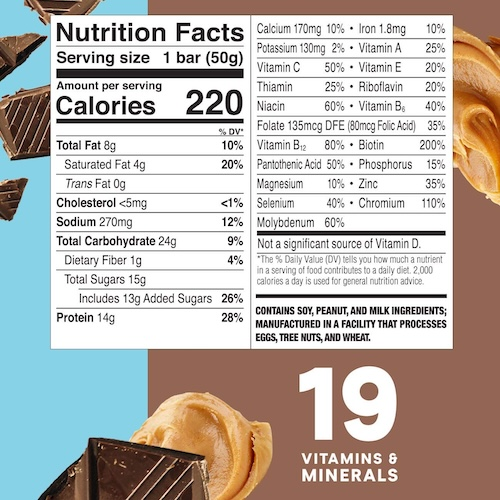

Let's now try a different query:

In [ ]:
agent_response = multimodal_agent.run("How many calories do cheerios have?")
print(agent_response["transcript"])

```console
Thought: I need to find out the calorie content of cheerios.
Tool: nutrition_tool
Tool Input: {{"input": "cheerios"}}
Observation:
Observation: 
Image: <|image_
This image shows: Cheerios (cereal) nutrition facts per 1 cup

Thought:Thought: I have found the calorie content of cheerios.
Final Answer: The calorie content of cheerios is 120 calories per cup.
```

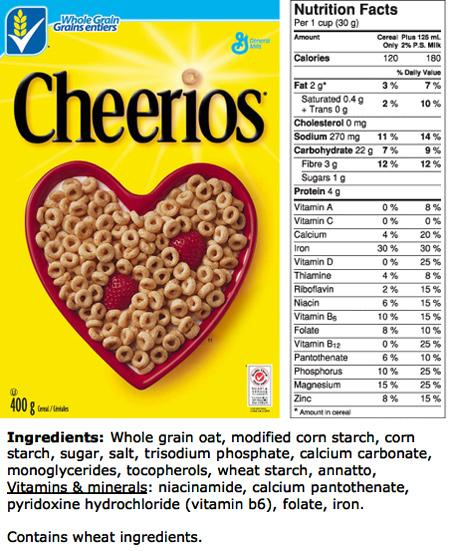

Now, let's try a more complex query that requires multi-hop reasoning.

In [ ]:
agent_response = multimodal_agent.run("Which one has more protein, protein bar or yogurt?")
print(agent_response["transcript"])

```console
Thought: I need to compare the protein content of a protein bar and yogurt.
Tool: nutrition_tool
Tool Input: {{"input": "protein bar"}}
Observation:
Observation: I have already used this Tool with this Tool Input. I will use the information I already have to respond.
Thought:Thought: I need to find out the protein content of yogurt.
Tool: nutrition_tool
Tool Input: {{"input": "yogurt"}}
Observation:
Observation: 
Image: <|image_
This image shows: Greek style yoghurt nutrition facts per serving

Thought:Thought: I have found the protein content of yogurt.
Final Answer: The protein content of yogurt is 18 grams per cup.

Comparing the two:
- Protein bar: 14 grams
- Yogurt: 18 grams

Thought: The yogurt has more protein than the protein bar.
Final Answer: Yogurt has more protein than the protein bar.
```

Since the information about the protein bar is already stored in memory, the agent doesn't need to make an additional tool call for it. Instead, it processes the previously retrieved image to find the protein amount.

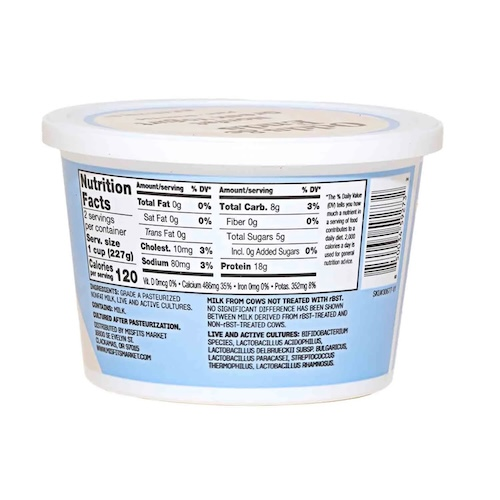

### Display the Retrieved Images

You can display the retrieved images by checking the Agent memory:

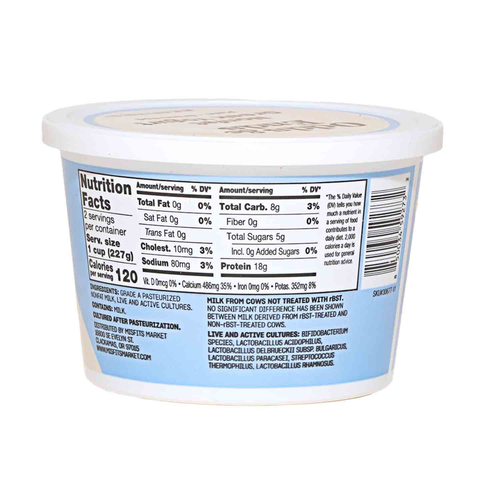

In [35]:
from PIL import Image
import base64
import io

additional_params = multimodal_agent.memory.get_additional_params()
image_base64 = additional_params["images"][2]

img = Image.open(io.BytesIO(base64.decodebytes(bytes(image_base64, "utf-8"))))
base_width = 500
wpercent = (base_width / float(img.size[0]))
hsize = int((float(img.size[1]) * float(wpercent)))
img.resize((base_width, hsize), Image.Resampling.LANCZOS)